--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


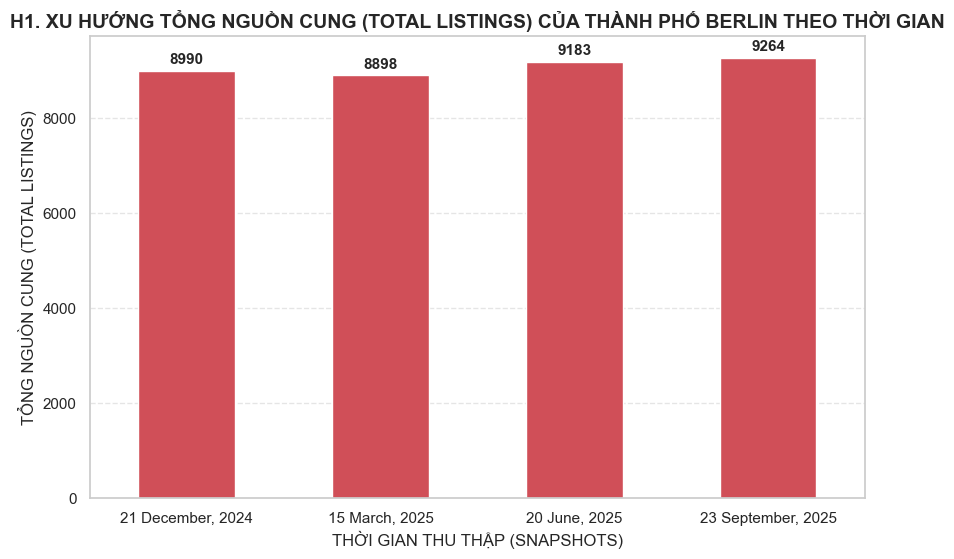

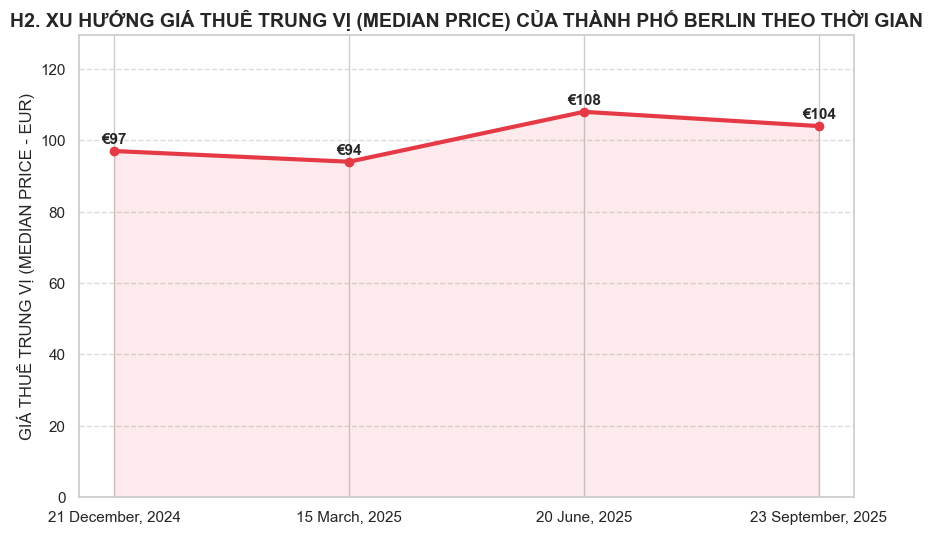

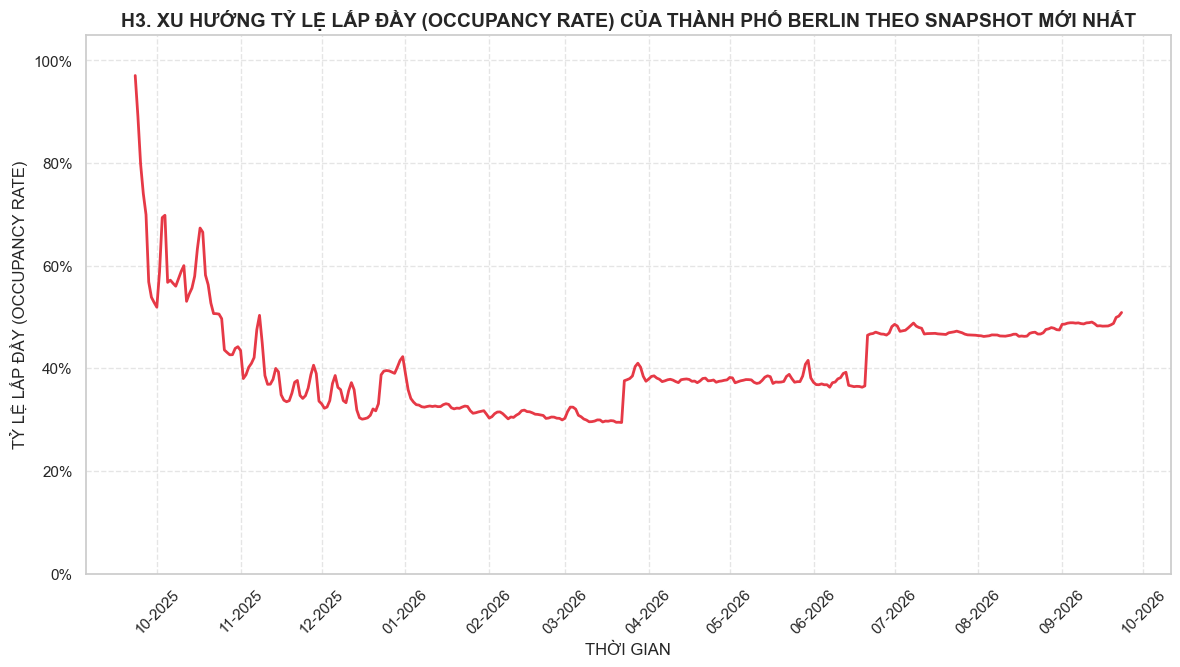

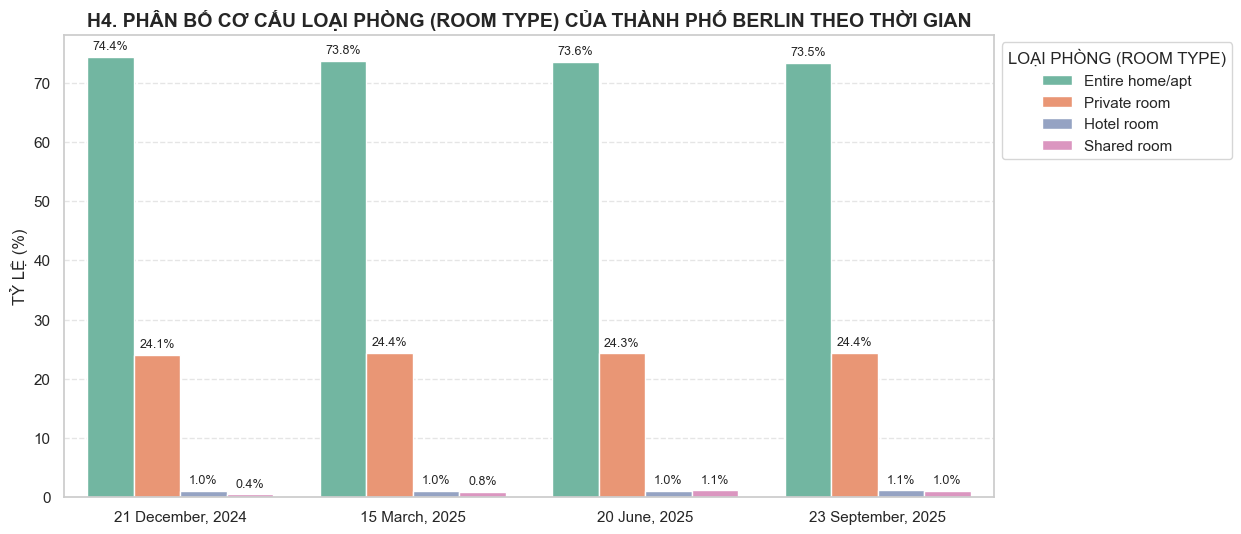

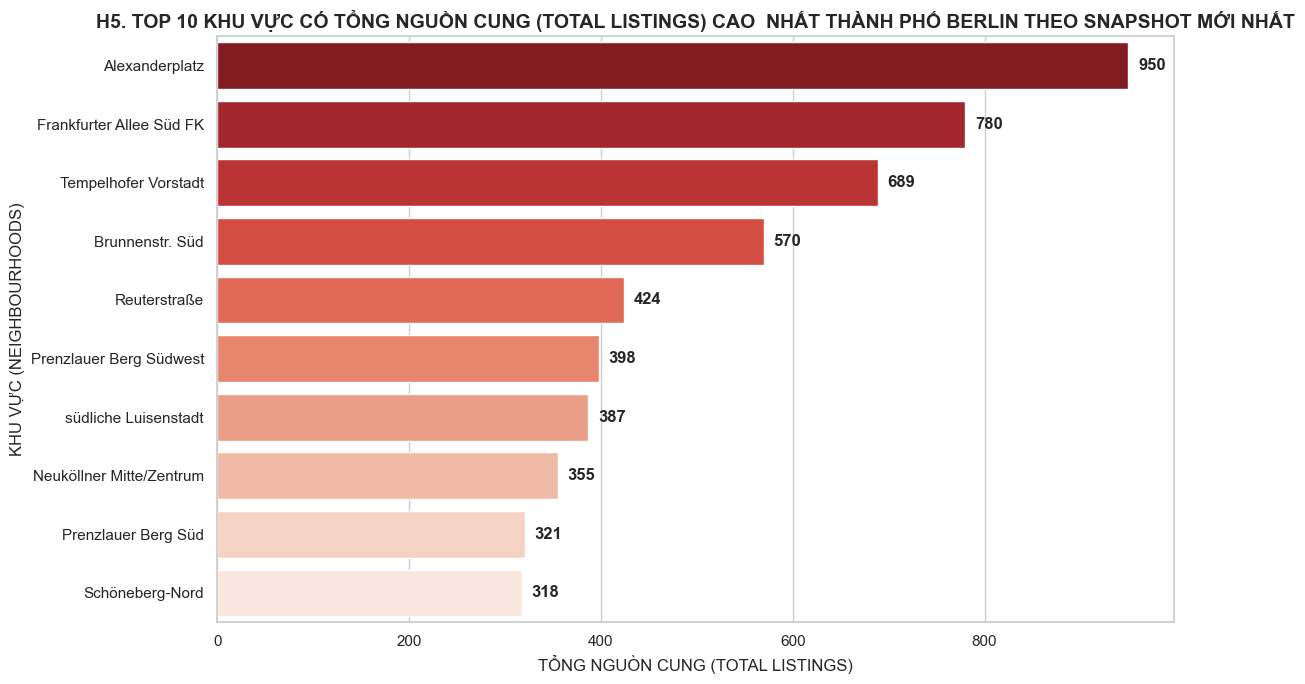

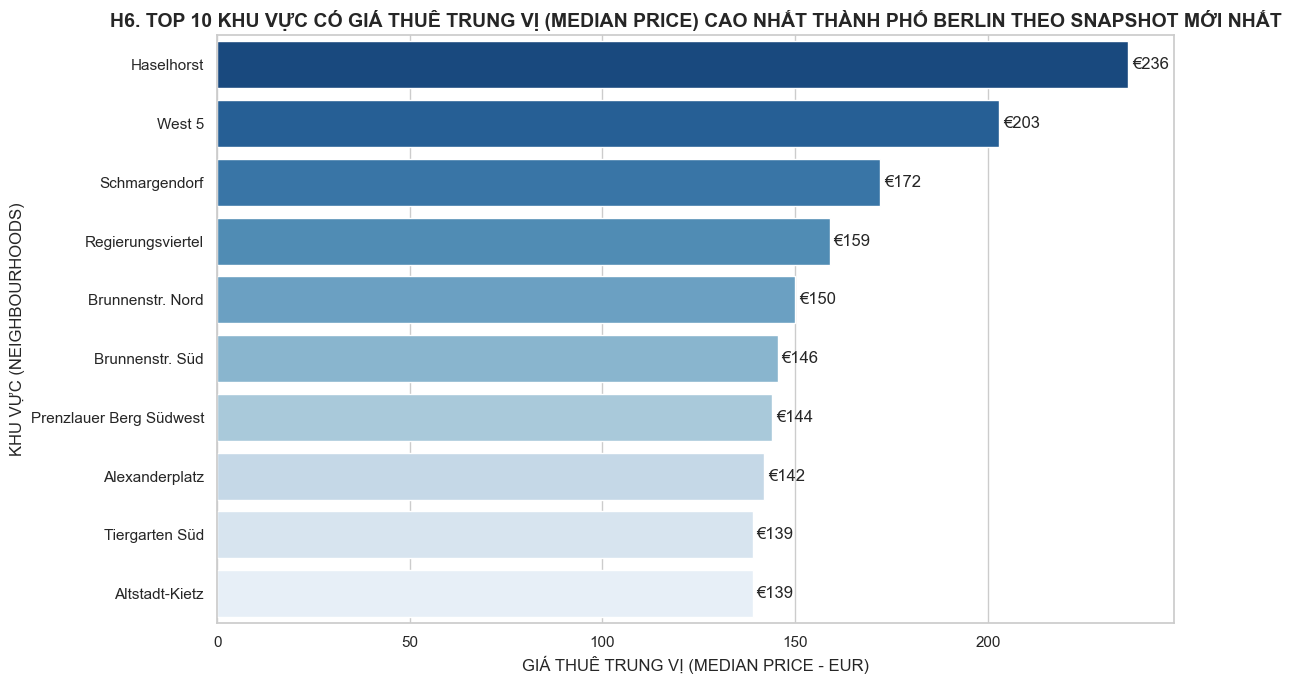

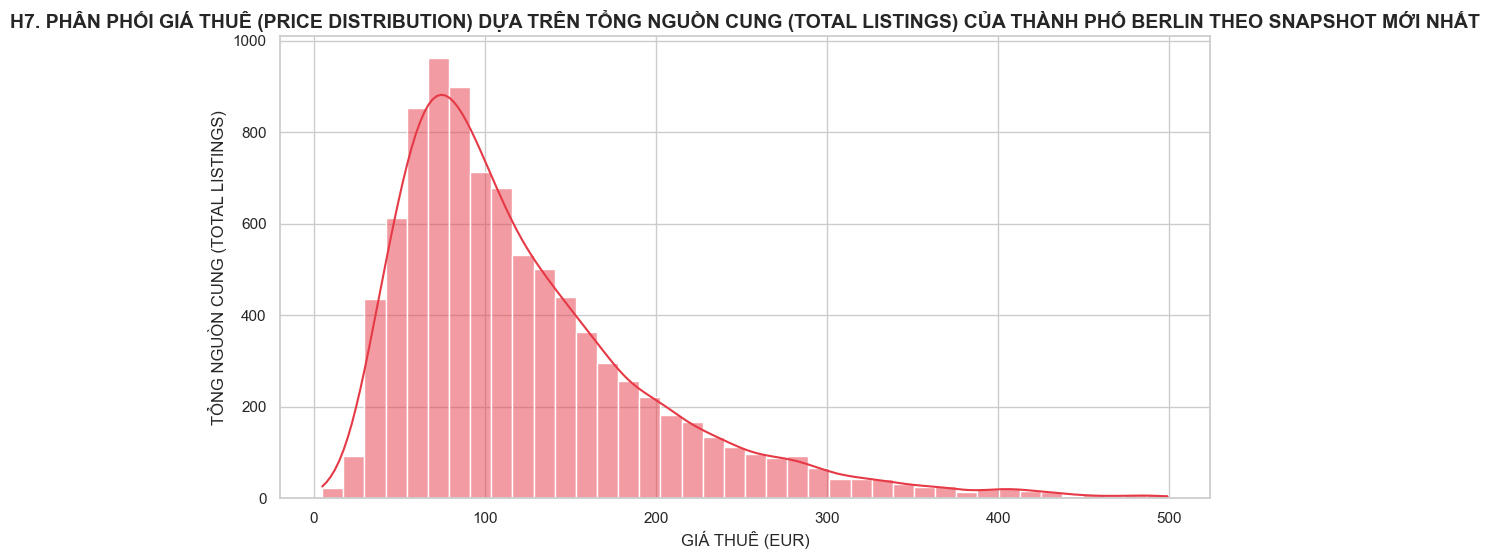

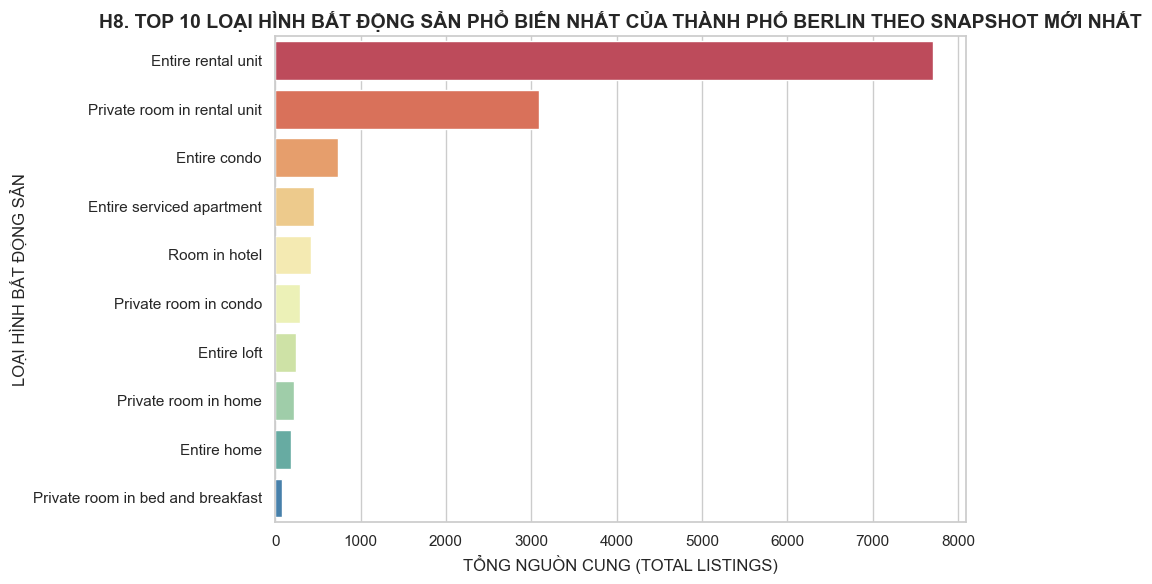

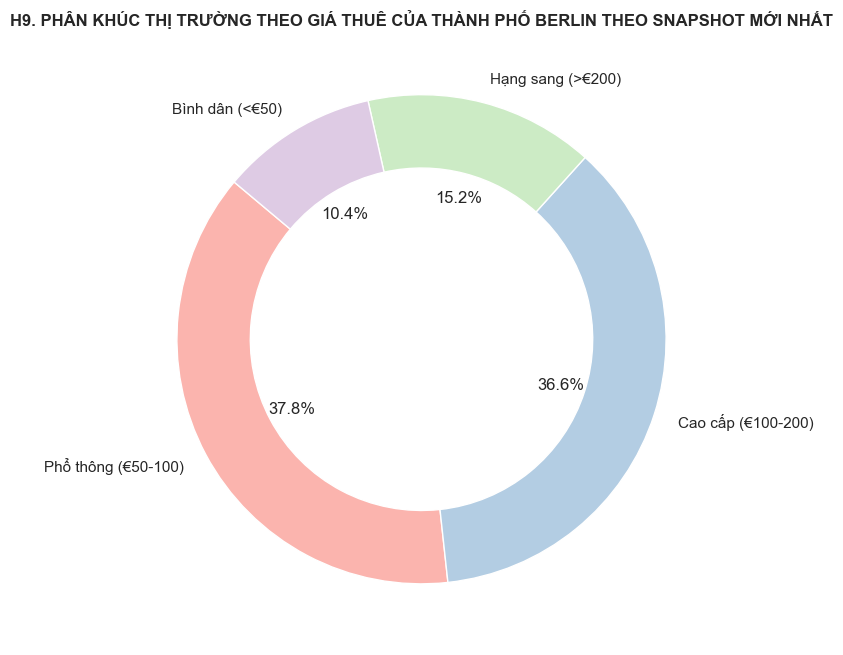

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# --- 1. THIẾT LẬP ---
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'berlin')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'berlin'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---")

# --- 2. NẠP DỮ LIỆU KPI ---
try:
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))

    def sort_by_date(df, date_col='snapshot_date'):
        df['dt'] = pd.to_datetime(df[date_col], errors='coerce')
        return df.sort_values('dt')

    kpi_supply = sort_by_date(kpi_supply)

    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"❌ Lỗi: Không tìm thấy file KPI. Chi tiết: {e}")
    kpi_supply = pd.DataFrame()


# --- 3. NẠP DỮ LIỆU CHI TIẾT ---
from datetime import datetime

def parse_snapshot_name(name):
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

df_detail = pd.DataFrame()
LATEST_SNAPSHOT = "Unknown"

if os.path.exists(PROCESSED_DIR):
    raw_snaps = [
        d for d in os.listdir(PROCESSED_DIR)
        if os.path.isdir(os.path.join(PROCESSED_DIR, d))
    ]

    snapshots = [s for s in raw_snaps if parse_snapshot_name(s) is not None]
    snapshots = sorted(snapshots, key=lambda x: parse_snapshot_name(x), reverse=True)

    for snap in snapshots:
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        if os.path.exists(file_path):
            try:
                temp = pd.read_csv(file_path, low_memory=False)
                if not temp.empty and 'price_numeric' in temp.columns:
                    df_detail = temp
                    LATEST_SNAPSHOT = snap
                    break
            except: continue


# --- 4. VẼ BIỂU ĐỒ ---

# === H1: Xu hướng Nguồn Cung ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#E63946', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H2: Xu hướng Giá ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#E63946')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#E63946', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H3: Occupancy ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')

    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#E63946', linewidth=2)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.title('H3. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
        plt.xlabel('THỜI GIAN')
        plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim(0, 1.05)
        plt.xticks(rotation=45)
        plt.savefig(os.path.join(FIGURES_DIR, 'berlin_03_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()

# === H4: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H4. PHÂN BỐ CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_04_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


    
# === H5: Top 10 khu vực nhiều listing nhất ===
if not df_detail.empty:
    top_supply = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_supply, y='neighbourhood_cleansed', x='count', 
                hue='neighbourhood_cleansed', palette='Reds_r', legend=False)
    plt.title('H5. TOP 10 KHU VỰC CÓ TỔNG NGUỒN CUNG (TOTAL LISTINGS) CAO  NHẤT THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    for i, v in enumerate(top_supply['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_05_top10_supply.pdf'))
    plt.show()


# === H6: Top 10 khu vực đắt nhất ===
if not df_detail.empty:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(data=neigh_price, y='neighbourhood_cleansed', x='price_numeric', 
                hue='neighbourhood_cleansed', palette='Blues_r', legend=False)
    plt.title('H6. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CAO NHẤT THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center')
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_06_top10_price.pdf'))
    plt.show()


# === H7: Histogram giá ===
if not df_detail.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_detail[df_detail['price_numeric'] < 500]['price_numeric'], kde=True, bins=40, color='#E63946')
    plt.title('H7. PHÂN PHỐI GIÁ THUÊ (PRICE DISTRIBUTION) DỰA TRÊN TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_07_price_distribution.pdf'), format='pdf', bbox_inches='tight')
    plt.show()






# === H8: Top 10 Loại hình Bất động sản  ===
if not df_detail.empty and 'property_type' in df_detail.columns:
    top_props = df_detail['property_type'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_props.index, x=top_props.values, 
                hue=top_props.index, palette='Spectral', legend=False)
    plt.title('H8. TOP 10 LOẠI HÌNH BẤT ĐỘNG SẢN PHỔ BIẾN NHẤT CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('LOẠI HÌNH BẤT ĐỘNG SẢN')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_08_property_type.pdf'))
    plt.show()



# === H9: Phân khúc Giá (Donut Chart) ===
if not df_detail.empty:
    plt.figure(figsize=(8, 8))
    bins = [0, 50, 100, 200, 10000]
    labels = ['Bình dân (<€50)', 'Phổ thông (€50-100)', 'Cao cấp (€100-200)', 'Hạng sang (>€200)']
    df_detail['price_segment'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels)
    seg_counts = df_detail['price_segment'].value_counts()
    
    plt.pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%', startangle=140, 
            colors=sns.color_palette('Pastel1'), wedgeprops=dict(width=0.3))
    plt.title('H9. PHÂN KHÚC THỊ TRƯỜNG THEO GIÁ THUÊ CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_09_price_segments.pdf'))
    plt.show()




